<a href="https://colab.research.google.com/github/paramp-ratap/CircuitVerseDocs/blob/master/Saidl%20part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: extract dataset of images from /content/train.7z

import os
import shutil

# Install py7zr if not already installed
try:
    import py7zr
except ImportError:
    print("Installing py7zr...")
    !pip install py7zr
    import py7zr

# Specify the path to your 7z archive
archive_path = '/content/train.7z'

# Specify the directory where you want to extract the images
extract_dir = '/content/extracted_images'  # Create this directory if it doesn't exist

# Create the extract directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)
    print(f"Created directory: {extract_dir}")

# Extract the contents of the 7z archive
try:
    with py7zr.SevenZipFile(archive_path, mode='r') as z:
        z.extractall(path=extract_dir)
        print(f"Successfully extracted contents to: {extract_dir}")

except FileNotFoundError:
    print(f"Error: Archive file not found at {archive_path}")

except Exception as e:
    print(f"An error occurred: {e}")

Successfully extracted contents to: /content/extracted_images


In [2]:
import pandas as pd

file_path = '/content/trainLabels.csv'
data = pd.read_csv(file_path)

data.head(), data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      50000 non-null  int64 
 1   label   50000 non-null  object
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


(   id       label
 0   1        frog
 1   2       truck
 2   3       truck
 3   4        deer
 4   5  automobile,
 None)


Training on noise rate: 0.2
Epoch 1/5, Loss: 2.3044
Epoch 2/5, Loss: 2.3033
Epoch 3/5, Loss: 2.3033
Epoch 4/5, Loss: 2.3028
Epoch 5/5, Loss: 2.3029
Accuracy for noise rate 0.2: 0.1006

Training on noise rate: 0.5
Epoch 1/5, Loss: 2.3047
Epoch 2/5, Loss: 2.3035
Epoch 3/5, Loss: 2.3031
Epoch 4/5, Loss: 2.3030
Epoch 5/5, Loss: 2.3028
Accuracy for noise rate 0.5: 0.1014

Training on noise rate: 0.8
Epoch 1/5, Loss: 2.3049
Epoch 2/5, Loss: 2.3035
Epoch 3/5, Loss: 2.3030
Epoch 4/5, Loss: 2.3028
Epoch 5/5, Loss: 2.3029
Accuracy for noise rate 0.8: 0.0995


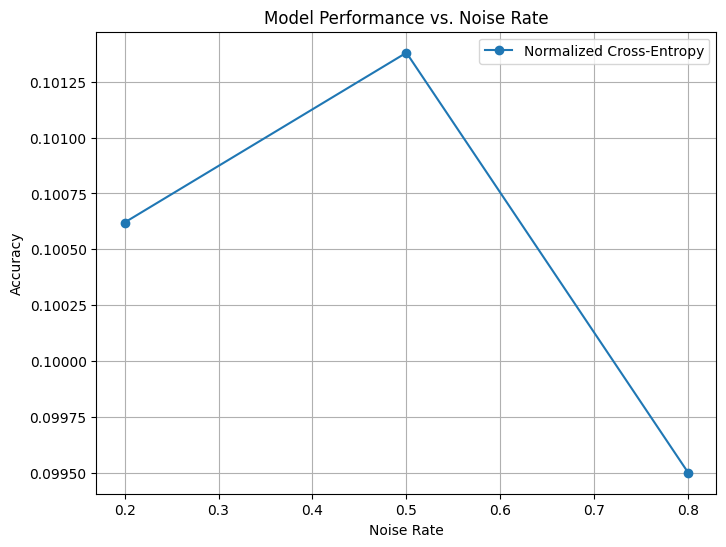

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define a dataset wrapper
class NoisyDataset(Dataset):
    def __init__(self, data, label_to_index):
        self.data = data
        self.label_to_index = label_to_index
        self.classes = list(label_to_index.keys())
        self.num_classes = len(self.classes)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        x = torch.randn(100)  # 100-dim feature vector (mock data since features are missing)
        y = self.label_to_index[sample['label']]
        return x, y

# Step 2: Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Step 3: Define loss functions
class NormalizedCrossEntropy(nn.Module):
    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=-1)
        return -torch.log(probs.gather(1, targets.unsqueeze(1))).mean()

class NormalizedFocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super().__init__()
        self.gamma = gamma

    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=-1)
        focal_term = (1 - probs.gather(1, targets.unsqueeze(1))).pow(self.gamma)
        return (focal_term * -torch.log(probs.gather(1, targets.unsqueeze(1)))).mean()

# Step 4: Training function
def train_model(model, dataloader, loss_fn, optimizer, epochs=5, device="cpu"):
    model.to(device)
    model.train()

    for epoch in range(epochs):
        total_loss = 0.0
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")

# Step 5: Evaluation function
def evaluate_model(model, dataloader, device="cpu"):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            _, preds = torch.max(outputs, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    return correct / total

# Step 6: Generate noisy datasets
def add_symmetric_noise(data, noise_rate, seed=42):
    np.random.seed(seed)
    noisy_data = data.copy()
    label_to_index = {label: i for i, label in enumerate(data['label'].unique())}
    index_to_label = {i: label for label, i in label_to_index.items()}
    noisy_data['label_index'] = noisy_data['label'].map(label_to_index)

    num_samples = len(noisy_data)
    num_noisy = int(noise_rate * num_samples)
    noisy_indices = np.random.choice(num_samples, num_noisy, replace=False)

    for idx in noisy_indices:
        original_label = noisy_data.at[idx, 'label_index']
        possible_labels = list(range(len(label_to_index)))
        possible_labels.remove(original_label)
        new_label = np.random.choice(possible_labels)
        noisy_data.at[idx, 'label_index'] = new_label

    noisy_data['label'] = noisy_data['label_index'].map(index_to_label)
    noisy_data.drop(columns=['label_index'], inplace=True)
    return noisy_data

# Step 7: Load and prepare data
label_to_index = {label: i for i, label in enumerate(data['label'].unique())}
noise_rates = [0.2, 0.5, 0.8]
datasets = {eta: NoisyDataset(add_symmetric_noise(data, eta), label_to_index) for eta in noise_rates}
dataloaders = {eta: DataLoader(ds, batch_size=64, shuffle=True) for eta, ds in datasets.items()}

# Step 8: Train and evaluate models
device = "cuda" if torch.cuda.is_available() else "cpu"
input_dim = 100  # Simulated feature vector size
results = {}

for eta, dataloader in dataloaders.items():
    print(f"\nTraining on noise rate: {eta}")
    model = SimpleNN(input_dim=input_dim, num_classes=len(label_to_index)).to(device)
    loss_fn = NormalizedCrossEntropy()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_model(model, dataloader, loss_fn, optimizer, epochs=5, device=device)
    accuracy = evaluate_model(model, dataloader, device=device)
    results[eta] = accuracy
    print(f"Accuracy for noise rate {eta}: {accuracy:.4f}")

# Step 9: Visualize results
plt.figure(figsize=(8, 6))
plt.plot(results.keys(), results.values(), marker='o', label="Normalized Cross-Entropy")
plt.title("Model Performance vs. Noise Rate")
plt.xlabel("Noise Rate")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()




Training with NCE on noise rate 0.2
Epoch 1/5, Loss: 2.3048
Epoch 2/5, Loss: 2.3035
Epoch 3/5, Loss: 2.3031
Epoch 4/5, Loss: 2.3030
Epoch 5/5, Loss: 2.3027
Accuracy with NCE on noise rate 0.2: 0.1013

Training with NFL on noise rate 0.2
Epoch 1/5, Loss: 1.8676
Epoch 2/5, Loss: 1.8662
Epoch 3/5, Loss: 1.8659
Epoch 4/5, Loss: 1.8655
Epoch 5/5, Loss: 1.8655
Accuracy with NFL on noise rate 0.2: 0.1017

Training with MAE on noise rate 0.2
Epoch 1/5, Loss: 0.9003
Epoch 2/5, Loss: 0.9000
Epoch 3/5, Loss: 0.8983
Epoch 4/5, Loss: 0.8993
Epoch 5/5, Loss: 0.8990
Accuracy with MAE on noise rate 0.2: 0.1019

Training with RCE on noise rate 0.2
Epoch 1/5, Loss: 2.3046
Epoch 2/5, Loss: 2.3032
Epoch 3/5, Loss: 2.3029
Epoch 4/5, Loss: 2.3028
Epoch 5/5, Loss: 2.3029
Accuracy with RCE on noise rate 0.2: 0.1019

Training with APL on noise rate 0.2
Epoch 1/5, Loss: 0.1319
Epoch 2/5, Loss: 0.0869
Epoch 3/5, Loss: 0.0862
Epoch 4/5, Loss: 0.0861
Epoch 5/5, Loss: 0.0859
Accuracy with APL on noise rate 0.2: 0.

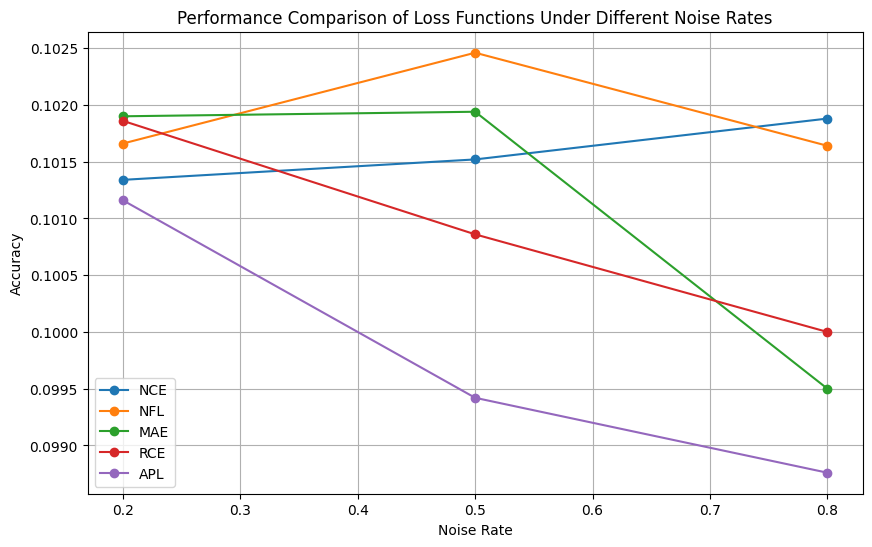

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define new loss functions: MAE, RCE, and APL (simulated)
class MeanAbsoluteError(nn.Module):
    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=-1)
        return torch.abs(probs.gather(1, targets.unsqueeze(1)) - 1).mean()

class ReverseCrossEntropy(nn.Module):
    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=-1)
        return -probs.gather(1, targets.unsqueeze(1)).log().mean()

class AsymmetricPolyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=2.0):
        super().__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=-1)
        focal_term = (1 - probs.gather(1, targets.unsqueeze(1))).pow(self.beta)
        asymmetric_term = probs.gather(1, targets.unsqueeze(1)).pow(self.alpha)
        return (focal_term * asymmetric_term * -torch.log(probs.gather(1, targets.unsqueeze(1)))).mean()

# Loss functions to evaluate
loss_functions = {
    "NCE": NormalizedCrossEntropy(),
    "NFL": NormalizedFocalLoss(),
    "MAE": MeanAbsoluteError(),
    "RCE": ReverseCrossEntropy(),
    "APL": AsymmetricPolyLoss(alpha=0.5, beta=2.0),
}

# Train and evaluate models for all loss functions
results = {loss_name: {} for loss_name in loss_functions.keys()}

for eta, dataloader in dataloaders.items():
    for loss_name, loss_fn in loss_functions.items():
        print(f"\nTraining with {loss_name} on noise rate {eta}")
        model = SimpleNN(input_dim=100, num_classes=len(label_to_index)).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Train the model
        train_model(model, dataloader, loss_fn, optimizer, epochs=5, device=device)

        # Evaluate the model
        accuracy = evaluate_model(model, dataloader, device=device)
        results[loss_name][eta] = accuracy
        print(f"Accuracy with {loss_name} on noise rate {eta}: {accuracy:.4f}")

# Plot results
plt.figure(figsize=(10, 6))
for loss_name, metrics in results.items():
    plt.plot(metrics.keys(), metrics.values(), marker='o', label=loss_name)

plt.title("Performance Comparison of Loss Functions Under Different Noise Rates")
plt.xlabel("Noise Rate")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()
